In [1]:
# package imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import timeimport pandas as pd

from time import sleep

from datetime import datetime

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from selenium.webdriver.firefox.options import Options

from bs4 import BeautifulSoup

import networkx as nx

#Suppress all scientific notation
pd.options.display.float_format = '{:20,.2f}'.format

#Suppress all scientific notation
pd.options.display.float_format = '{:20,.2f}'.format

### Each Neighborhood URL has a suffix I need to extract. Here's how

In [6]:
# URL of the webpage
url = "https://web.archive.org/web/20240331170832/https://atlanta.urbanize.city/neighborhoods"

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content of the webpage
soup = BeautifulSoup(response.content, "html.parser")

# Find all anchor tags (<a>) with href attribute containing "/neighborhood/"
neighborhood_links = soup.find_all("a", href=lambda href: href and "/neighborhood/" in href)

# Extract neighborhood names, URLs, and URL suffixes
neighborhood_data = []
for link in neighborhood_links:
    neighborhood_name = link.text.strip()
    neighborhood_url = f"https://atlanta.urbanize.city{link['href']}"
    url_suffix = link['href'].split('/neighborhood/')[1]
    mother_url = f"https://atlanta.urbanize.city/neighborhood/{url_suffix}"
    neighborhood_data.append({"neighborhood_name": neighborhood_name, "raw_url": neighborhood_url, "neighborhood_suffix": url_suffix, "mother_url": mother_url})

# Create DataFrame
neighborhoods_df = pd.DataFrame(neighborhood_data)

# Rename columns
#neighborhoods_df.rename(columns={"url_suffix": "neighborhood_suffix", "raw_url": "mother_url"}, inplace=True)

# Print the DataFrame
neighborhoods_df

,neighborhood_name,raw_url,neighborhood_suffix,mother_url
0,Midtown,https://atlanta.urbanize.city/web/202403311708...,midtown,https://atlanta.urbanize.city/neighborhood/mid...
1,Downtown,https://atlanta.urbanize.city/web/202403311708...,downtown-0,https://atlanta.urbanize.city/neighborhood/dow...
2,Citywide,https://atlanta.urbanize.city/web/202403311708...,citywide,https://atlanta.urbanize.city/neighborhood/cit...
3,Buckhead,https://atlanta.urbanize.city/web/202403311708...,buckhead,https://atlanta.urbanize.city/neighborhood/buc...
4,Old Fourth Ward,https://atlanta.urbanize.city/web/202403311708...,old-fourth-ward,https://atlanta.urbanize.city/neighborhood/old...
...,...,...,...,...
187,Westview,https://atlanta.urbanize.city/web/202403311708...,westview,https://atlanta.urbanize.city/neighborhood/wes...
188,Westwood Terrace,https://atlanta.urbanize.city/web/202403311708...,westwood-terrace,https://atlanta.urbanize.city/neighborhood/wes...
189,Whittier Mill Village,https://atlanta.urbanize.city/web/202403311708...,whittier-mill-village,https://atlanta.urbanize.city/neighborhood/whi...
190,Woodland Hills,https://atlanta.urbanize.city/web/202403311708...,woodland-hills-0,https://atlanta.urbanize.city/neighborhood/woo...


### The prefix years below indicate each year's calendar page. Therefore, if I concatenate each combination with the neighborhood mother_urls above, I will create a list of each neighborhood's calendar page

In [7]:
# Define the prefixes for true_url
prefixes = [
    "https://web.archive.org/web/20240000000000*/",
    "https://web.archive.org/web/20230000000000*/",
    "https://web.archive.org/web/20220000000000*/"
]

# Create lists to store the generated URLs and neighborhood names
urls = []
neighborhood_names = []

# Iterate over each unique mother_url value
for mother_url, neighborhood_name in zip(neighborhoods_df['mother_url'], neighborhoods_df['neighborhood_name']):
    # Concatenate each prefix with the current mother_url value to generate the true_url
    for prefix in prefixes:
        true_url = prefix + mother_url
        # Append the true_url to the list of URLs
        urls.append(true_url)
        # Append the neighborhood_name to the list of neighborhood names
        neighborhood_names.append(neighborhood_name)

# Create a DataFrame from the lists of URLs and neighborhood names
all_calendar_urls = pd.DataFrame({'true_url': urls, 'neighborhood_name': neighborhood_names})

# Display the resulting DataFrame
#all_calendar_urls.to_csv("all_calendar_urls", index=True)

all_calendar_urls


,true_url,neighborhood_name
0,https://web.archive.org/web/20240000000000*/ht...,Midtown
1,https://web.archive.org/web/20230000000000*/ht...,Midtown
2,https://web.archive.org/web/20220000000000*/ht...,Midtown
3,https://web.archive.org/web/20240000000000*/ht...,Downtown
4,https://web.archive.org/web/20230000000000*/ht...,Downtown
...,...,...
571,https://web.archive.org/web/20230000000000*/ht...,Woodland Hills
572,https://web.archive.org/web/20220000000000*/ht...,Woodland Hills
573,https://web.archive.org/web/20240000000000*/ht...,Woodstock
574,https://web.archive.org/web/20230000000000*/ht...,Woodstock


### Now I want to do the same for the homepage and also extract all HREF links, since that gets snapshots more frequently than the calendar pages

In [8]:
# List of URLs to scrape
urls = [
    "https://web.archive.org/web/20240000000000*/https://atlanta.urbanize.city/",
    "https://web.archive.org/web/20230000000000*/https://atlanta.urbanize.city/",
    "https://web.archive.org/web/20220000000000*/https://atlanta.urbanize.city/"
]

# List to store all HREF links, snapshot dates, and neighborhood names from all URLs
all_href_links = []
snapshot_dates = []
neighborhood_names = []

# Initialize WebDriver
driver = webdriver.Firefox()

# Iterate over each URL
for url in urls:
    # Open the webpage
    driver.get(url)

    # Wait for the page to load completely (max 10 seconds)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "calendar-day")))

    # Find all elements with class "calendar-day"
    calendar_day_elements = driver.find_elements(By.CLASS_NAME, "calendar-day")

    # Iterate over each calendar-day element
    for element in calendar_day_elements:
        # Find the anchor tag (a) within the calendar-day element
        anchor_tag = element.find_element(By.TAG_NAME, "a")
        # Get the value of the href attribute
        href_link = anchor_tag.get_attribute("href")
        # Append the href link to the list
        all_href_links.append(href_link)
        # Extract the snapshot date from the href link and convert it to datetime format
        snapshot_date_str = href_link.split("/web/")[1][:8]  # Extract the date part from the href link
        snapshot_date = datetime.strptime(snapshot_date_str, "%Y%m%d")  # Convert date string to datetime object
        snapshot_dates.append(snapshot_date)
        # Add "home_page" as neighborhood_name for URLs without a mother_url suffix
        neighborhood_names.append("home_page")

# Close the WebDriver
driver.quit()

# Create a DataFrame from the lists of href links, snapshot dates, and neighborhood names
home_page_href_snapshot_df = pd.DataFrame({
    "href_links": all_href_links,
    "snapshot_date": snapshot_dates,
    "neighborhood_name": neighborhood_names
})

# Print the DataFrame
home_page_href_snapshot_df

,href_links,snapshot_date,neighborhood_name
0,https://web.archive.org/web/20240102/https://a...,2024-01-02,home_page
1,https://web.archive.org/web/20240113/https://a...,2024-01-13,home_page
2,https://web.archive.org/web/20240201/https://a...,2024-02-01,home_page
3,https://web.archive.org/web/20240311/https://a...,2024-03-11,home_page
4,https://web.archive.org/web/20240324/https://a...,2024-03-24,home_page
...,...,...,...
56,https://web.archive.org/web/20220928/https://a...,2022-09-28,home_page
57,https://web.archive.org/web/20221001/https://a...,2022-10-01,home_page
58,https://web.archive.org/web/20221101/https://a...,2022-11-01,home_page
59,https://web.archive.org/web/20221201/https://a...,2022-12-01,home_page


### This will now iterate through every calendar page and pull out the HREF link to each day's snapshot. calendar-day indicates days snapshots were taken on

In [10]:
# List to store all HREF links, snapshot dates, and neighborhood names
all_href_links = []
snapshot_dates = []
neighborhood_names = []

# Initialize WebDriver
driver = webdriver.Firefox()

# Set the timeout period (in seconds)
timeout = 20

# Iterate over each row in all_calendar_urls
for index, row in all_calendar_urls.iterrows():
    try:
        # Open the webpage
        driver.get(row['true_url'])

        # Wait for the page to load completely
        WebDriverWait(driver, timeout).until(EC.presence_of_element_located((By.CLASS_NAME, "calendar-day")))

        # Find all elements with class "calendar-day"
        calendar_day_elements = driver.find_elements(By.CLASS_NAME, "calendar-day")

        # Iterate over each calendar-day element
        for element in calendar_day_elements:
            # Find the anchor tag (a) within the calendar-day element
            anchor_tag = element.find_element(By.TAG_NAME, "a")
            # Get the value of the href attribute
            href_link = anchor_tag.get_attribute("href")
            # Append the href link to the list
            all_href_links.append(href_link)
            # Extract the snapshot date from the href link and convert it to datetime format
            snapshot_date_str = href_link.split("/web/")[1][:8]  # Extract the date part from the href link
            snapshot_date = datetime.strptime(snapshot_date_str, "%Y%m%d")  # Convert date string to datetime object
            snapshot_dates.append(snapshot_date)
            # Add the neighborhood_name from all_calendar_urls
            neighborhood_names.append(row['neighborhood_name'])
    except (TimeoutException, NoSuchElementException) as e:
        print(f"Error: {e} - Element not found for URL: {row['true_url']}")

# Close the WebDriver
driver.quit()

# Create a DataFrame from the lists of href links, snapshot dates, and neighborhood names
all_href_snapshots = pd.DataFrame({
    "href_links": all_href_links,
    "snapshot_date": snapshot_dates,
    "neighborhood_name": neighborhood_names
})

# Print the DataFrame
all_href_snapshots

Error: Message: 
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:193:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:511:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16
 - Element not found for URL: https://web.archive.org/web/20240000000000*/https://atlanta.urbanize.city/neighborhood/acworth
Error: Message: 
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:193:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:511:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16
 - Element not found for URL: https://web.archive.org/web/20240000000000*/https://atlanta.urbanize.city/neighborhood/adair-park
Error: Message: 
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@ch

,href_links,snapshot_date,neighborhood_name
0,https://web.archive.org/web/20240113/https://a...,2024-01-13,Midtown
1,https://web.archive.org/web/20240324/https://a...,2024-03-24,Midtown
2,https://web.archive.org/web/20240331/https://a...,2024-03-31,Midtown
3,https://web.archive.org/web/20230131/https://a...,2023-01-31,Midtown
4,https://web.archive.org/web/20230323/https://a...,2023-03-23,Midtown
...,...,...,...
1047,https://web.archive.org/web/20220426/https://a...,2022-04-26,Woodstock
1048,https://web.archive.org/web/20220621/https://a...,2022-06-21,Woodstock
1049,https://web.archive.org/web/20220629/https://a...,2022-06-29,Woodstock
1050,https://web.archive.org/web/20220816/https://a...,2022-08-16,Woodstock


#### Now I can combine both HREF data sets. The portion above should probably be adjusted to run headless and in batches of 10 so it's faster

In [11]:
# Combine the two DataFrames
combined_df = pd.concat([all_href_snapshots, home_page_href_snapshot_df], ignore_index=True)

# Print the combined DataFrame
combined_df

,href_links,snapshot_date,neighborhood_name
0,https://web.archive.org/web/20240113/https://a...,2024-01-13,Midtown
1,https://web.archive.org/web/20240324/https://a...,2024-03-24,Midtown
2,https://web.archive.org/web/20240331/https://a...,2024-03-31,Midtown
3,https://web.archive.org/web/20230131/https://a...,2023-01-31,Midtown
4,https://web.archive.org/web/20230323/https://a...,2023-03-23,Midtown
...,...,...,...
1108,https://web.archive.org/web/20220928/https://a...,2022-09-28,home_page
1109,https://web.archive.org/web/20221001/https://a...,2022-10-01,home_page
1110,https://web.archive.org/web/20221101/https://a...,2022-11-01,home_page
1111,https://web.archive.org/web/20221201/https://a...,2022-12-01,home_page


#### From the HREF URLs, we can now scrape every individual Post URL. This should also be double checked as a headless 10 batch run in the future

In [13]:
# Initialize a list to store all post links
all_post_links = []

# Initialize WebDriver
driver = webdriver.Firefox()

# Iterate over each URL in the href_links column
for url in combined_df['href_links']:
    # Load URL in the browser
    driver.get(url)
    
    # Extract URLs of individual posts on the page
    post_links = driver.find_elements(By.XPATH, "//div[contains(@class, 'article-thumb-title')]/ancestor::a")

    # Loop through each post link and extract the URL
    for post_link in post_links:
        post_url = "https://web.archive.org/web/" + post_link.get_attribute("href")
        # Add the post link to the list
        all_post_links.append(post_url)

# Close the WebDriver
driver.quit()

# Remove duplicates from the list of post links
unique_post_links = list(set(all_post_links))

# Print the list of unique post links
unique_post_links

['https://web.archive.org/web/https://atlanta.urbanize.city/post/avondale-estates-town-green-approves-mixed-use-development-images',
 'https://web.archive.org/web/https://atlanta.urbanize.city/post/replace-compound-development-project-coming-republic-sports-social',
 'https://web.archive.org/web/https://atlanta.urbanize.city/post/artifex-designed-riverside-modern-has-12-car-garage-38m-price',
 'https://web.archive.org/web/https://atlanta.urbanize.city/post/ponce-city-market-signal-house-beltline-tower-pricing-new-images',
 'https://web.archive.org/web/https://atlanta.urbanize.city/post/mall-west-end-has-landed-potential-buyer-again',
 'https://web.archive.org/web/https://atlanta.urbanize.city/post/westside-park-park-vue-townhomes-change-tactics-nip-prices',
 'https://web.archive.org/web/https://atlanta.urbanize.city/post/jordan-justus-decongesting-curb',
 'https://web.archive.org/web/https://atlanta.urbanize.city/post/first-look-fronting-beltlines-southside-trail-194-unit-project-has-l

#### Now that I have the URL for every post possible on Urbanize, I want to scrape them all the following way. Again, update this in the future to run headless and in a batch of 10

In [14]:
# Function to extract data from a single post URL
def extract_data_from_post(post_url):
    # Initialize WebDriver
    driver = webdriver.Firefox()
    
    # Initialize error flag
    error_occurred = False

    # Load post URL
    driver.get(post_url)

    # Define the locator values and their corresponding variable names
    locators = {
        "neighborhood_tag": "neighborhood-tag",
        "article_title": "article-title",
        "article_subtitle": "article-subtitle",
        "article_byline": "article-byline",
        "article_tags_list": "article-tag"
    }

    # Find the elements using locators and assign them to variables
    data = {}
    for var_name, locator_value in locators.items():
        # Replace '-' with '_' in variable name
        var_name = var_name.replace("-", "_")
        try:
            # Find the element using its class name and locator value
            data[var_name] = driver.find_element(By.CLASS_NAME, locator_value).text
        except:
            data[var_name] = None
            # Set error flag to True
            error_occurred = True

    # Special handling for article_tags_list since it's a list of elements
    article_tags_list = driver.find_elements(By.CLASS_NAME, "article-tag")
    # Extract the text content of each element in article_tags_list and join them with a comma
    data['article_tags'] = ", ".join([tag.text for tag in article_tags_list])

    try:
        # Split article_byline into separate columns
        byline_parts = data['article_byline'].split(' ')
        # Join the first three parts to form the date string and remove any leading or trailing whitespace
        date_published_str = ' '.join(byline_parts[:3]).strip(',')
        # Parse the date string into a datetime object and format it
        date_published_obj = datetime.strptime(date_published_str, '%B %d, %Y')
        data['date_published'] = date_published_obj.strftime('%Y-%m-%d')

        # Extract time_published and author
        time_author_str = byline_parts[3]  # Extract time_published and author together

        # Split the time_author string using regex
        time_author_parts = re.split(r'(\d{1,2}:\d{2}[AP]M)', time_author_str)

        # Parse the time string into a datetime object and format it
        time_published_obj = datetime.strptime(time_author_parts[1], '%I:%M%p')
        data['time_published'] = time_published_obj.strftime('%H:%M')

        # Extract the author and number of comments
        data['author'] = time_author_parts[2].strip().title() + ' ' + byline_parts[4].title() # Capitalize author's name
        data['number_of_comments'] = byline_parts[5]

        # Remove the original article_byline entry from the data dictionary
        del data['article_byline']

    except Exception as e:
        print(f"Error occurred while extracting data from {post_url}: {e}")
        # Set error flag to True
        error_occurred = True

    # Close the WebDriver
    driver.quit()

    return data, error_occurred

# Initialize an empty list to store data for each post
posts_data = []

# Initialize an empty list to store URLs that encountered errors
error_urls = []

# Initialize WebDriver
driver = webdriver.Firefox()

# Iterate over each unique post link
for post_url in unique_post_links:
    # Extract data from the post URL and append to the list
    post_data, error_occurred = extract_data_from_post(post_url)
    if error_occurred:
        error_urls.append(post_url)
    else:
        posts_data.append(post_data)

# Close the WebDriver
driver.quit()

# Create DataFrame from the list of post data
all_articles = pd.DataFrame(posts_data)

# Reorder columns
desired_order = ['article_title', 'article_subtitle', 'date_published', 'time_published', 'author', 'number_of_comments', 'neighborhood_tag', 'article_tags']
all_articles = all_articles[desired_order]

# Print the DataFrame
all_articles

# Print URLs that encountered errors
print("URLs that encountered errors:")
print(error_urls)

Error occurred while extracting data from https://web.archive.org/web/https://atlanta.urbanize.city/post/georgia-tech-project-modernize-section-historic-football-stadium: time data '' does not match format '%B %d, %Y'
Error occurred while extracting data from https://web.archive.org/web/https://atlanta.urbanize.city/post/westin-gwinnett-county-first-four-star-hotel-open-photos: 'NoneType' object has no attribute 'split'
Error occurred while extracting data from https://web.archive.org/web/https://atlanta.urbanize.city/post/photos-pullman-districts-surprise-football-arena-quickly-takes-shape: 'NoneType' object has no attribute 'split'
Error occurred while extracting data from https://web.archive.org/web/https://atlanta.urbanize.city/post/championship-match-atlantas-worst-parking-garage-tourney-vote-now: 'NoneType' object has no attribute 'split'
Error occurred while extracting data from https://web.archive.org/web/https://atlanta.urbanize.city/post/plans-coming-together-hero-walk-throug

#### View the final data frame - did it work?

In [15]:
# Drop duplicates based on 'article_title' and 'date_published' columns
all_articles_unique = all_articles.drop_duplicates(subset=['article_title', 'date_published'])

# Print the DataFrame with unique values
all_articles_unique

,article_title,article_subtitle,date_published,time_published,author,number_of_comments,neighborhood_tag,article_tags
0,Avondale Estates greenlights mixed-use build o...,"Project at cusp of downtown calls for retail, ...",2023-01-12,08:13,Josh Green,COMMENTS,AVONDALE ESTATES,"64 N. AVONDALE ROAD, ATG PARTNERS, FABRIC DEVE..."
1,Massive development in works to replace Compou...,New York developer Tishman Speyer pitches mixe...,2022-05-03,07:57,Josh Green,COMMENTS,MARIETTA STREET ARTERY,"1008 BRADY AVENUE NW, TISHMAN SPEYER, COMPOUND..."
2,Artifex-designed riverside modern has 12-car g...,Recent construction near historic Vinings incl...,2021-07-23,10:14,Josh Green,COMMENTS,SMYRNA/VININGS,"3713 COCHISE DRIVE SE, ARTIFEX, COBB COUNTY, C..."
3,Fresh images: Ponce City Market's first new to...,21-story Signal House project on BeltLine flau...,2023-06-22,13:02,Josh Green,COMMENTS,OLD FOURTH WARD,"680 NORTH AVENUE NE, SIGNAL HOUSE, PONCE CITY ..."
4,The Mall West End has landed a potential buyer...,Another New York City firm is reportedly inter...,2021-08-30,08:12,Josh Green,COMMENTS,WEST END,"850 OAK STREET SW, PRUSIK GROUP, HARLEM, SOUTH..."
...,...,...,...,...,...,...,...,...
1871,"UPDATE: 26-story tower, 465 apartments unveile...",Midtown Exchange project would continue Selig'...,2022-04-12,18:02,Josh Green,COMMENTS,MIDTOWN,"12TH STREET AT PEACHTREE WALK, MIDTOWN EXCHANG..."
1872,"Near Reynoldstown's BeltLine section, 85 condo...",Site a block from Eastside Trail was formerly ...,2021-11-10,14:47,Josh Green,COMMENTS,REYNOLDSTOWN,"195 CHESTER AVENUE SE, TOLL BROTHERS APARTMENT..."
1873,"Mixed-use East Cobb Walk breaks ground, replac...","Developer's approach is ""much like Avalon and ...",2022-04-12,14:41,Josh Green,COMMENTS,MARIETTA,"2692 SANDY PLAINS ROAD, MARIETTA, EAST COBB WA..."
1874,"Visuals, prices emerge for condo 'stacks' on B...",Brick-clad Stein Steel multifamily offerings t...,2023-03-30,14:33,Josh Green,COMMENTS,REYNOLDSTOWN,"933 KIRKWOOD AVENUE SE, EMPIRE STEIN STEEL, ST..."


#### The comment column seemed to incorrectly scrape - I have a few other test versions of that code so I should use that go back and debug it to work correctly

#### Additionally, too many URLs were skipped. I need to go back and set which ones to skip - like the neighborhood competition ones - but some of these links do have the date info they said they couldn't scrape.

In [31]:
# Save the DataFrame as a CSV file
all_articles_unique.to_csv('all_articles_unique.csv', index=False)

#### Basic Graphs

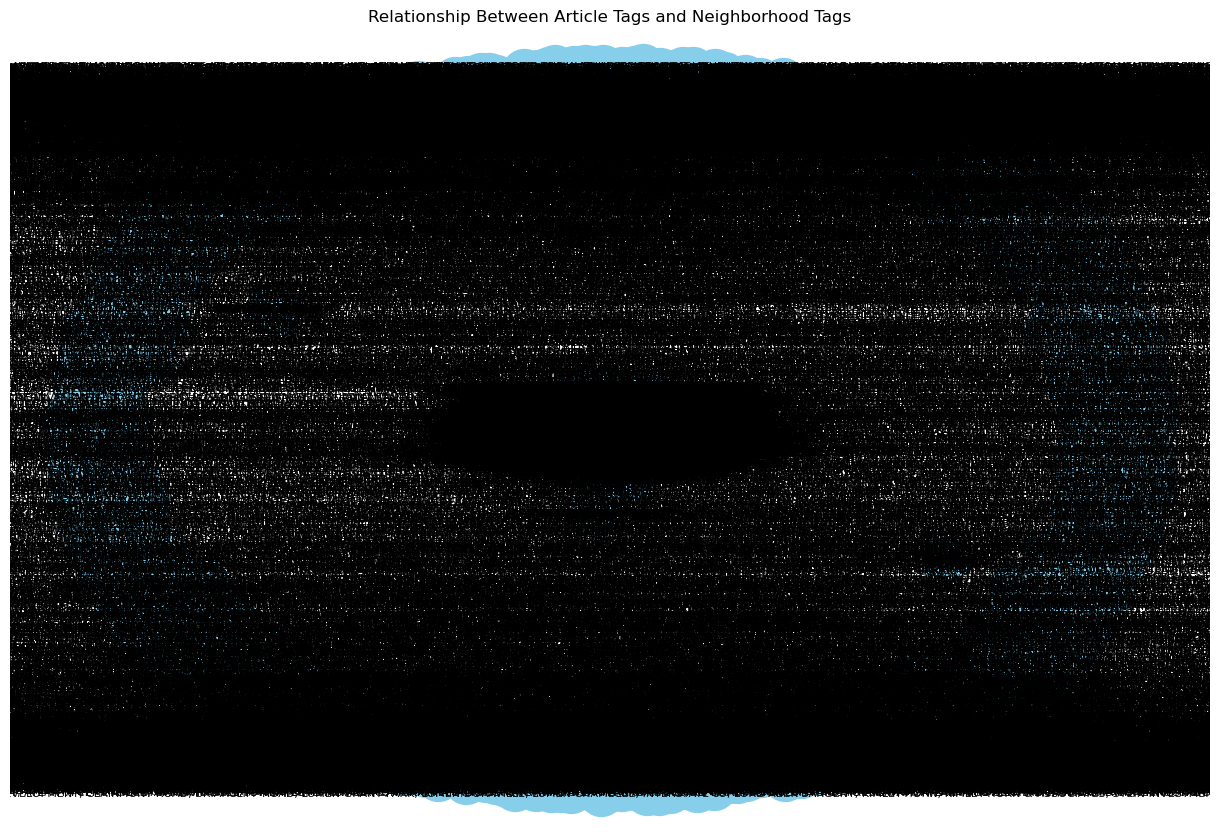

In [20]:
# Extract unique tags from article_tags and neighborhood_tag
all_tags = set(all_articles_unique['article_tags'].tolist() + all_articles_unique['neighborhood_tag'].tolist())

# Create a graph
G = nx.Graph()

# Add nodes to the graph
for tag in all_tags:
    G.add_node(tag)

# Iterate through each row in the DataFrame
for _, row in all_articles_unique.iterrows():
    article_tags = row['article_tags'].split(',')
    neighborhood_tag = row['neighborhood_tag']
    
    # Connect article_tags with neighborhood_tag
    for tag in article_tags:
        G.add_edge(tag, neighborhood_tag)

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, font_size=8, node_size=1000, node_color='skyblue', edge_color='gray', pos=nx.spring_layout(G, seed=42))
plt.title('Relationship Between Article Tags and Neighborhood Tags')
plt.show()


#### I'll have to narrow down my selection and play with sentiment to make it work. Let's try some basic histograms

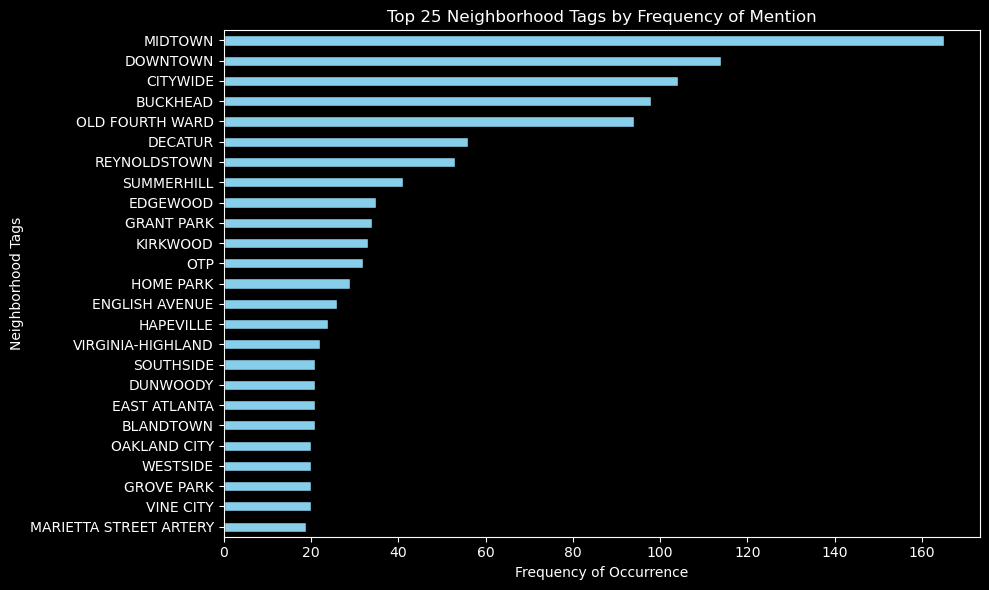

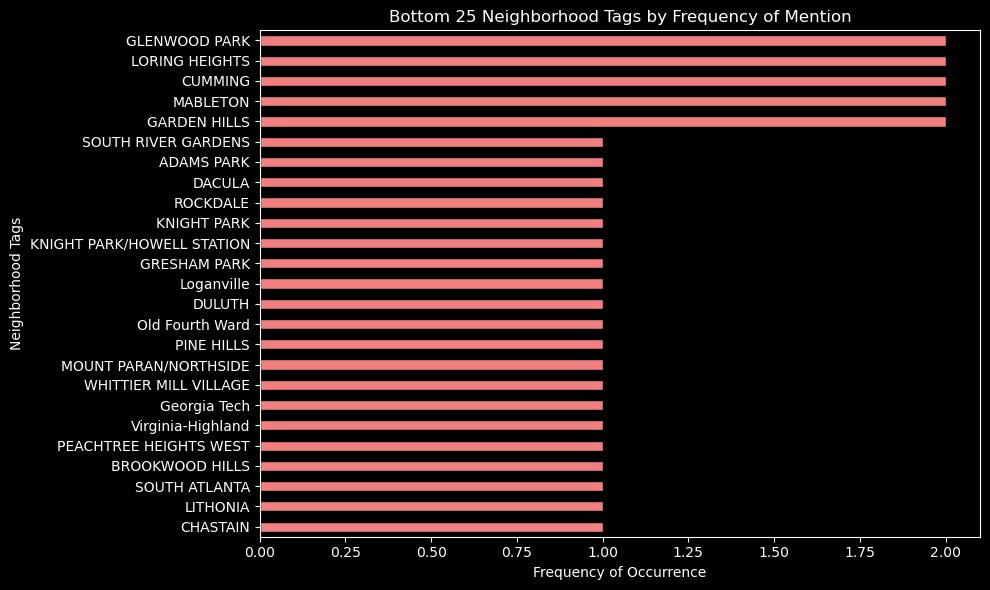

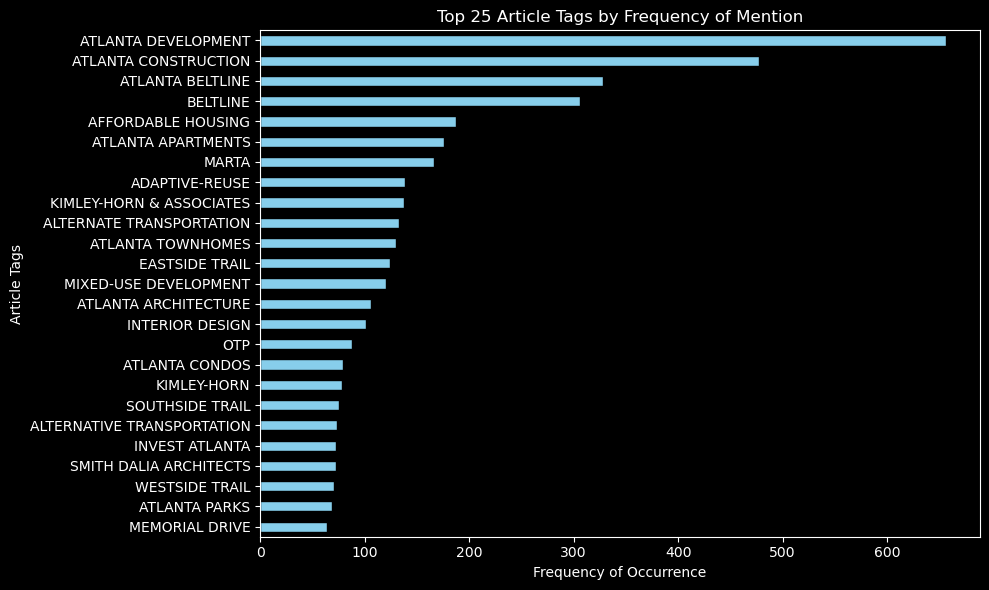

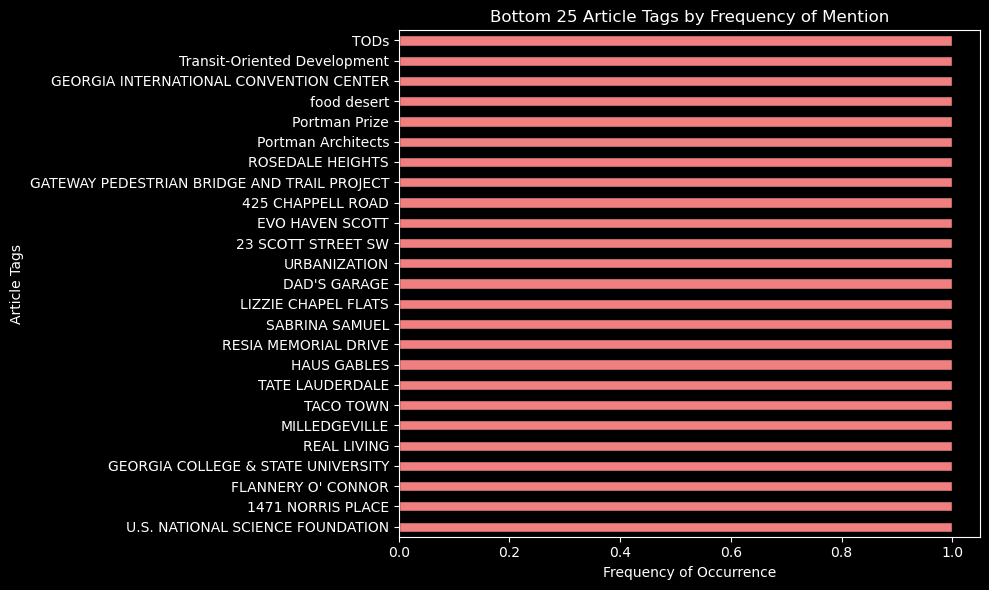

In [25]:
# Split multiple tags and create a list of all tags for neighborhoods and articles
all_neighborhood_tags = [tag.strip() for tags in all_articles_unique['neighborhood_tag'].str.split(',').tolist() for tag in tags]
all_article_tags = [tag.strip() for tags in all_articles_unique['article_tags'].str.split(',').tolist() for tag in tags]

# Create DataFrames to count the frequency of each tag
neighborhood_tag_counts = pd.Series(all_neighborhood_tags).value_counts()
article_tag_counts = pd.Series(all_article_tags).value_counts()

# Sort the tags by their frequency
neighborhood_tag_counts_sorted = neighborhood_tag_counts.sort_values()
article_tag_counts_sorted = article_tag_counts.sort_values()

# Extract the top 25 and bottom 25 tags for neighborhoods and articles
top_25_neighborhood_tags = neighborhood_tag_counts_sorted[-25:]
bottom_25_neighborhood_tags = neighborhood_tag_counts_sorted[:25]
top_25_article_tags = article_tag_counts_sorted[-25:]
bottom_25_article_tags = article_tag_counts_sorted[:25]

# Plot the frequencies for neighborhoods
plt.figure(figsize=(10, 6), facecolor='black')
plt.style.use('dark_background')
top_25_neighborhood_tags.plot(kind='barh', color='skyblue', edgecolor='black')
plt.xlabel('Frequency of Occurrence')
plt.ylabel('Neighborhood Tags')
plt.title('Top 25 Neighborhood Tags by Frequency of Mention')
plt.tight_layout()
plt.savefig('top_25_neighborhood_tags.png')
plt.show()

plt.figure(figsize=(10, 6), facecolor='black')
plt.style.use('dark_background')
bottom_25_neighborhood_tags.plot(kind='barh', color='lightcoral', edgecolor='black')
plt.xlabel('Frequency of Occurrence')
plt.ylabel('Neighborhood Tags')
plt.title('Bottom 25 Neighborhood Tags by Frequency of Mention')
plt.tight_layout()
plt.savefig('bottom_25_neighborhood_tags.png')
plt.show()

# Plot the frequencies for articles
plt.figure(figsize=(10, 6), facecolor='black')
plt.style.use('dark_background')
top_25_article_tags.plot(kind='barh', color='skyblue', edgecolor='black')
plt.xlabel('Frequency of Occurrence')
plt.ylabel('Article Tags')
plt.title('Top 25 Article Tags by Frequency of Mention')
plt.tight_layout()
plt.savefig('top_25_article_tags.png')
plt.show()

plt.figure(figsize=(10, 6), facecolor='black')
plt.style.use('dark_background')
bottom_25_article_tags.plot(kind='barh', color='lightcoral', edgecolor='black')
plt.xlabel('Frequency of Occurrence')
plt.ylabel('Article Tags')
plt.title('Bottom 25 Article Tags by Frequency of Mention')
plt.tight_layout()
plt.savefig('bottom_25_article_tags.png')
plt.show()


/var/folders/jm/3pr5r3qn5kj1jbb1kk_lcn8c0000gn/T/ipykernel_22951/1924672580.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_articles_unique['date_published'] = pd.to_datetime(all_articles_unique['date_published'])
/var/folders/jm/3pr5r3qn5kj1jbb1kk_lcn8c0000gn/T/ipykernel_22951/1924672580.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_articles_unique['month_year'] = all_articles_unique['date_published'].dt.to_period('M')


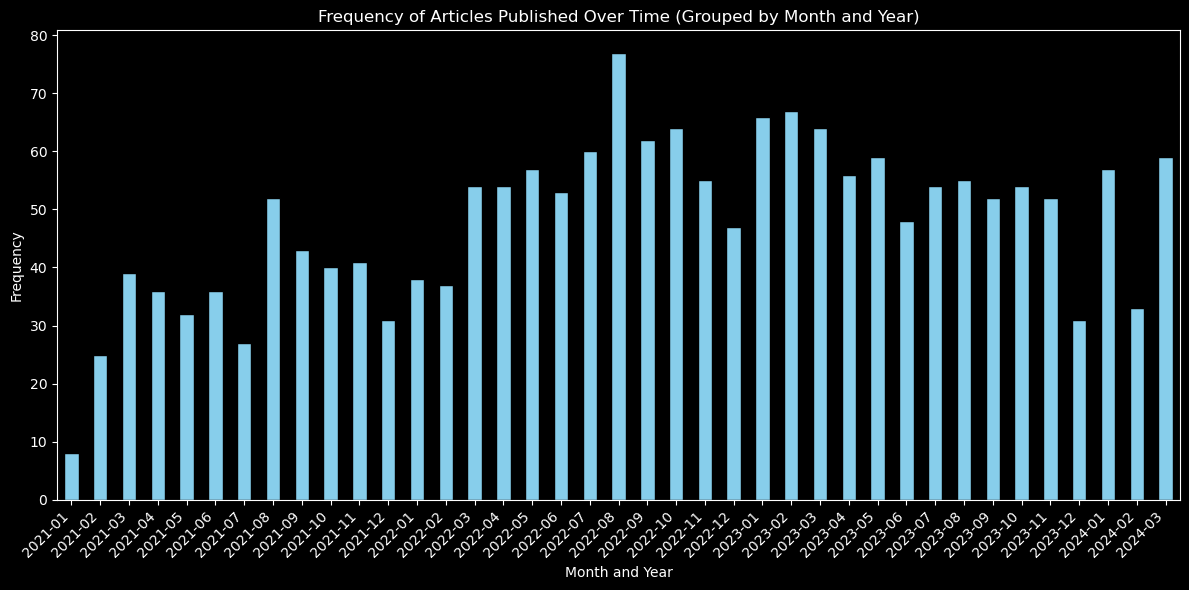

In [27]:
# Convert 'date_published' column to datetime if it's not already
all_articles_unique['date_published'] = pd.to_datetime(all_articles_unique['date_published'])

# Extract month and year
all_articles_unique['month_year'] = all_articles_unique['date_published'].dt.to_period('M')

# Group by month and year, count the frequency, and sort by month_year
monthly_counts = all_articles_unique.groupby('month_year').size().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.style.use('dark_background')
monthly_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Month and Year')
plt.ylabel('Frequency')
plt.title('Frequency of Articles Published Over Time (Grouped by Month and Year)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('frequency_of_articles_published_over_time_grouped.png')
plt.show()


/var/folders/jm/3pr5r3qn5kj1jbb1kk_lcn8c0000gn/T/ipykernel_22951/1877651107.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


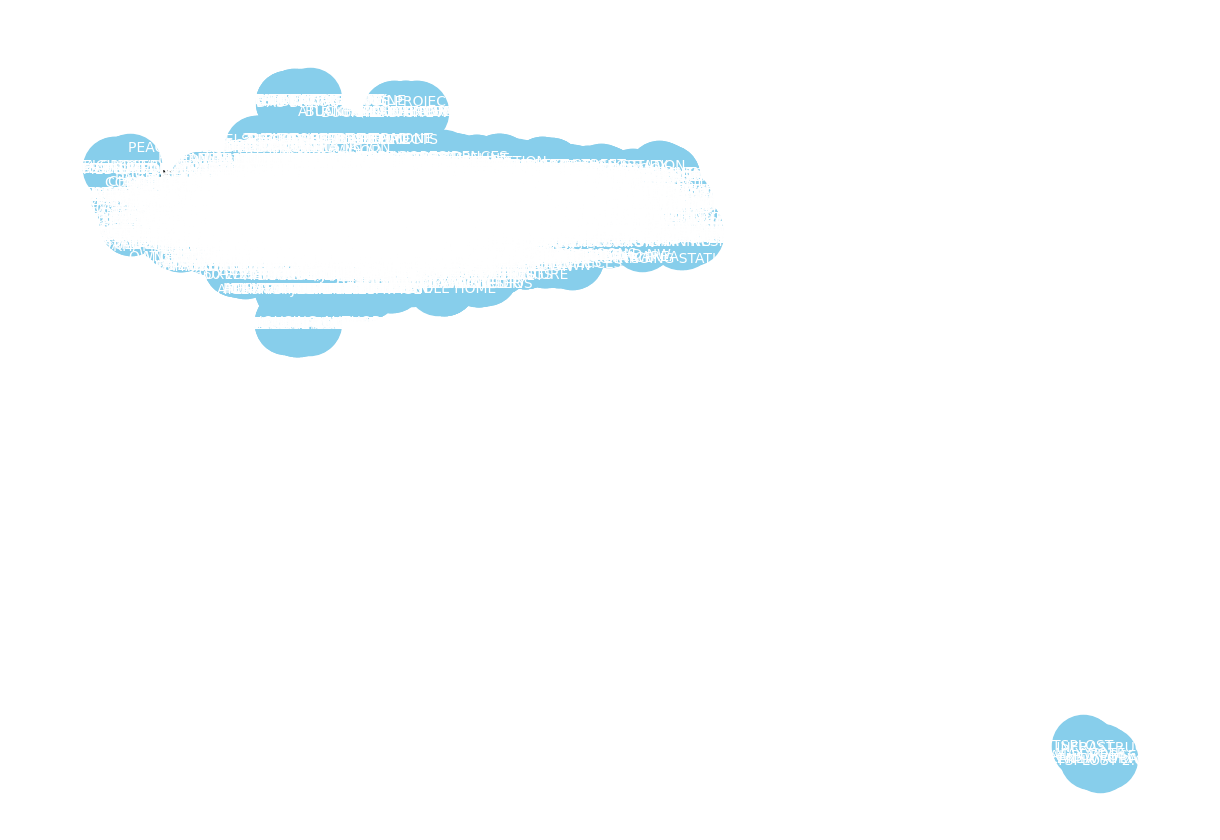

In [29]:
# Assuming you have a DataFrame named all_articles_unique
# Filter the DataFrame to include only specified neighborhood_tags
selected_neighborhoods = ['MIDTOWN', 'DOWNTOWN', 'CITYWIDE', 'BUCKHEAD', 'OLD FOURTH WARD']
filtered_df = all_articles_unique[all_articles_unique['neighborhood_tag'].isin(selected_neighborhoods)]

# Create an empty graph
G = nx.Graph()

# Iterate over each row in the filtered DataFrame
for _, row in filtered_df.iterrows():
    # Split article_tags into individual tags
    tags = [tag.strip() for tag in row['article_tags'].split(',')]
    # Create edges between each pair of tags
    edges = [(tags[i], tags[j]) for i in range(len(tags)) for j in range(i+1, len(tags))]
    # Add edges to the graph
    G.add_edges_from(edges)

# Count the frequency of edges between each pair of tags
edge_weights = nx.get_edge_attributes(G, 'weight')

# Filter nodes based on degree
min_degree = 2
nodes_to_keep = [node for node, degree in G.degree() if degree >= min_degree]
G_filtered = G.subgraph(nodes_to_keep)

# Visualize the network
plt.figure(figsize=(12, 8))
plt.style.use('dark_background')
pos = nx.spring_layout(G_filtered, seed=42)
nx.draw(G_filtered, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_color='white')
nx.draw_networkx_edge_labels(G_filtered, pos, edge_labels=edge_weights, font_color='white')
plt.title('Network Analysis of Article Tags for Selected Neighborhoods')
plt.tight_layout()
plt.savefig('network_analysis_article_tags.png')
plt.show()


#### This one didn't work either...I'll have to try another day